## Machine-learning-based fault interpretation
### Dependencies

In [19]:
import os
import cv2
import time
import json
import glob
import cmapy
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchsummary import summary
from common.classes import (
    SeismicDataset
)
from common.utils import (
    get_sliding_wnd_params,
    get_sliding_wnd_patches,
    window_2d,
    recover_img_from_patches,
)

### Dataset related parameters

In [2]:
stage = 'test'
dataset_root = './dataset'
dataset_proc = f'{dataset_root}/thebe_processed'

### Patch related parameters

In [3]:
with open(f'{dataset_proc}/patch_params.json', 'r+') as f:
    patch_params = json.load(f)

patch_sz = patch_params['patch_sz']
step = patch_params['step']
overlap_sz = patch_sz - step
print(f'Patch size: {patch_sz}')
print(f'Step: {step}')

Patch size: 96
Step: 48


### Load an inference model

In [18]:
alg = "unet"
merge_method = "smooth"  # smooth average crop
if alg == "unet":
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    filename = "unet_96_48_900200_seed"
    model_path = './checkpoints/noaugmodelsseed/{}.model'.format(
        filename)
elif alg == "deeplab":
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    filename = "mobilenet_96_48_900200_seed"
    model_path = './checkpoints/noaugmodelsseed/{}.model'.format(
        filename)
elif alg == "hed":
    from model_zoo.HED import HED
    model = HED()
    print("use model HED")
    filename = "hed_96_48_900200_seed3"
    model_path = './checkpoints/noaugmodelsseed/{}.model'.format(
        filename)
elif alg == "rcf":
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    filename = "rcf_96_48_900200_seed"
    model_path = './checkpoints/noaugmodelsseed/{}.model'.format(
        filename)
else:
    print("please enter a valid model")

save_root = 'inf_result'
save_path = f'{save_root}/{filename}_{merge_method}'
print(model_path)
print(save_path)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    devcie = torch.device('cpu')

model.load_state_dict(torch.load(model_path))
model.to(device)

summary(model, (1, patch_sz, patch_sz))

use model Unet
./checkpoints/noaugmodelsseed/unet_96_48_900200_seed.model
inf_result/unet_96_48_900200_seed_smooth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         Dropout2d-4           [-1, 32, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           9,248
       BatchNorm2d-6           [-1, 32, 96, 96]              64
              ReLU-7           [-1, 32, 96, 96]               0
         Dropout2d-8           [-1, 32, 96, 96]               0
       double_conv-9           [-1, 32, 96, 96]               0
        MaxPool2d-10           [-1, 32, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          18,496
      BatchNorm2d-12           [-1, 64, 48, 48]     

### Process test dataset

In [7]:
seismic_list = glob.glob(f'{dataset_proc}/{stage}/seismic/*.npy')
fault_list = glob.glob(f'{dataset_proc}/{stage}/annotation/*.npy')

print(f'Testing for {len(fault_list)} samples')

recovered_imgs = []
faults = []
elapsed_time = 0
for seismic_path, fault_path in zip(seismic_list, fault_list):
    seismic = np.load(seismic_path)
    fault = np.load(fault_path)
    faults.append(fault)

    start = time.time()
    Z, XL = fault.shape
    padding, cnt = get_sliding_wnd_params((XL, Z), patch_sz, step)
    num_patches = cnt[0] * cnt[1]

    patches = get_sliding_wnd_patches(seismic, padding, patch_sz, step)
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, 1)
    
    batch_size = 64
    dataset = SeismicDataset(patches)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False
    )

    preds = []
    for imgs in data_loader:
        imgs = Variable(imgs.cuda())
        outputs = model(imgs)
        preds.extend(outputs.detach().cpu())
        if len(preds) >= num_patches:
            stacked = torch.stack(preds).detach().cpu().numpy()[:num_patches]
            preds = preds[num_patches:]

            if merge_method == "smooth":
                weights = window_2d(wnd_sz=patch_sz, power=2)
                stacked = np.moveaxis(stacked, -3, -1)
                stacked = np.array([patch * weights for patch in stacked])
                stacked = stacked.reshape((cnt[1], cnt[0], patch_sz, patch_sz))
                recovered = recover_img_from_patches(stacked, (Z, XL), padding, overlap_sz)
                recovered_imgs.append(recovered)
            else:
                print('invalid merge method')
    end = time.time()
    elapsed_time += end - start

avg_exe_time = elapsed_time / len(fault_list)
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Average execution time: {avg_exe_time:.2f} seconds')

Testing for 703 samples
Total elapsed time: 983.55 seconds
Average execution time: 1.40 seconds


### Save inference results

In [22]:
os.makedirs(save_path, exist_ok=True)
os.makedirs(f'{save_root}/fault', exist_ok=True)

for i in range(len(recovered_imgs)):
    np.save(f'{save_path}/{i:08}.npy', recovered_imgs[i])
    np.save(f'{save_root}/fault/{i:08}.npy', faults[i])

### Illustrate inference results

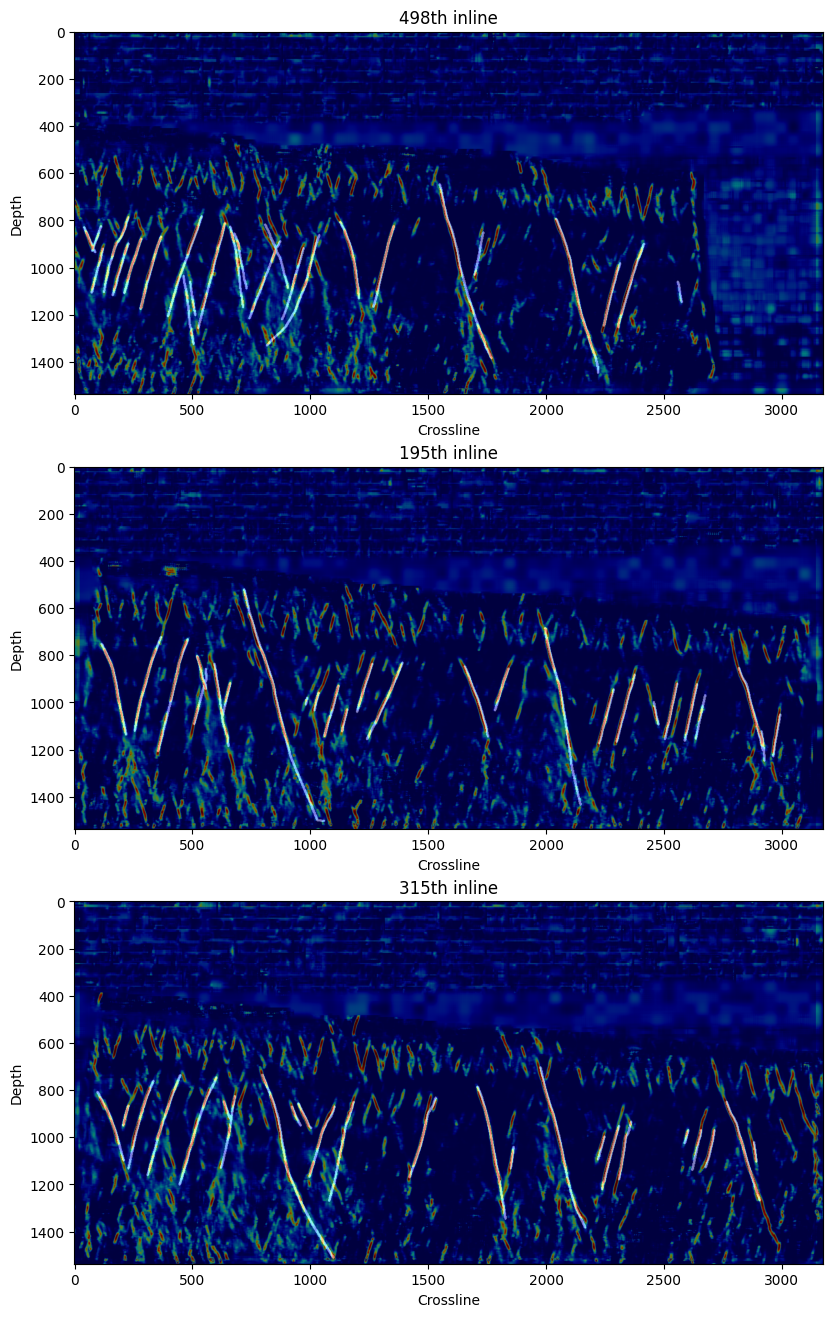

In [26]:
fault_list = glob.glob(f'{save_root}/fault/*.npy')

random.seed()
plt.figure(figsize=(20, 16))
for i in range(3):
    sample = random.randint(0, len(fault_list))
    seismic = np.load(f'{save_path}/{sample:08}.npy')
    fault = np.load(fault_list[sample])
    heatmap = cv2.applyColorMap((seismic * 255).astype(np.uint8), cmapy.cmap('jet_r'))
    plt.subplot(int(f'31{i + 1}'))
    plt.imshow(heatmap)
    plt.imshow(fault, cmap='gray', alpha=0.5)
    plt.title(f'{sample}th inline')
    plt.xlabel('Crossline')
    plt.ylabel('Depth')